<a href="https://colab.research.google.com/github/carlschroedl/computational-redistricting/blob/main/computational-redistricting-of-wisconsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Redistricting of Wisconsin
This notebook adapts the [Getting started with GerryChain](https://gerrychain.readthedocs.io/en/latest/user/quickstart.html) and [Running a Chain with Recom](https://gerrychain.readthedocs.io/en/latest/user/recom.html) examples from [MGGG](https://mggg.org/) to work with Wisconsin data.

## Install [GerryChain](https://gerrychain.readthedocs.io/en/latest/), Set up Notebook

In [ ]:
!pip install gerrychain

from IPython.display import display, Markdown
from pprint import pprint

     |████████████████████████████████| 54 kB 975 kB/s 
     |████████████████████████████████| 994 kB 8.3 MB/s 
     |████████████████████████████████| 15.4 MB 33 kB/s 
     |████████████████████████████████| 6.3 MB 27.0 MB/s 


## Download MGGG's [Pre-Processed WI Data](https://github.com/mggg-states/WI-shapefiles).

In [ ]:
!wget 'https://github.com/mggg-states/WI-shapefiles/raw/master/wisconsin2020_graph.json'

--2021-09-14 09:44:05--  https://github.com/mggg-states/WI-shapefiles/raw/master/wisconsin2020_graph.json
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mggg-states/WI-shapefiles/master/wisconsin2020_graph.json [following]
--2021-09-14 09:44:05--  https://raw.githubusercontent.com/mggg-states/WI-shapefiles/master/wisconsin2020_graph.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11915711 (11M) [text/plain]
Saving to: ‘wisconsin2020_graph.json’

wisconsin2020_graph 100%[===================>]  11.36M  --.-KB/s    in 0.1s    

2021-09-14 09:44:08 (87.1 MB/s) - ‘wisconsin2020_graph.json’ save

## Set up Initial Partition

In [ ]:
from gerrychain import Graph, GeographicPartition, Partition, Election
from gerrychain.updaters import Tally, cut_edges

graph = Graph.from_json("./wisconsin2020_graph.json")
print("Preview of node attributes:")
pprint(graph.nodes[0])

elections = [
    # Attributes documented here https://github.com/mggg-states/WI-shapefiles#metadata

    #Election("SEN10", {"Dem": "SEN10D", "Rep": "SEN10R"}),
    Election("SEN12", {"Dem": "SSEN12D", "Rep": "SSEN12R"}),
    #Election("SEN16", {"Dem": "SSEN16D", "Rep": "SSEN16D"}),
    Election("PRES12", {"Dem": "PRES12D", "Rep": "PRES12R"}),
    #Election("PRES16", {"Dem": "PRES16D:", "Rep": "PRES16R:"})
]

election_updaters = {election.name: election for election in elections}

base_updaters= {
  "cut_edges": cut_edges,
  "population": Tally("TOTPOP", alias="population"),
}

combined_updaters = {
    **base_updaters,
    **election_updaters
}

initial_partition = GeographicPartition(
    graph,
    assignment="CD", # Congressional=CD, State Senate = SEND, State Assembly = HDIST
    updaters=combined_updaters
)

Preview of node attributes:
{'2MOREVAP': 4.0,
 'AG14D': 94,
 'AG14R': 81,
 'AG18D': 102,
 'AG18R': 114,
 'AMINVAP': 3.0,
 'ASIANVAP': 0.0,
 'BVAP': 6.0,
 'CD': '3',
 'COUNTY': 'Adams',
 'COUNTYFP': '55001',
 'Code': 55001002750001.0,
 'Code-2': 1,
 'GOV12D': 104,
 'GOV12R': 95,
 'GOV14D': 101,
 'GOV14R': 85,
 'GOV18D': 99,
 'GOV18R': 120,
 'HDIST': '41',
 'HISP': 15.0,
 'HVAP': 8.0,
 'H_2MORE': 1.0,
 'H_AMIN': 0.0,
 'H_ASIAN': 0.0,
 'H_BLACK': 0.0,
 'H_NHPI': 0.0,
 'H_OTHER': 10.0,
 'H_WHITE': 4.0,
 'NHPIVAP': 0.0,
 'NH_2MORE': 11.0,
 'NH_AMIN': 3.0,
 'NH_ASIAN': 0.0,
 'NH_BLACK': 12.0,
 'NH_NHPI': 0.0,
 'NH_OTHER': 0.0,
 'NH_WHITE': 620.0,
 'OTHERVAP': 0.0,
 'PRES12D': 168,
 'PRES12R': 101,
 'PRES16D': 110,
 'PRES16R': 127,
 'Precinct': 'Adams - C 0001',
 'SEN12D': 148,
 'SEN12R': 99,
 'SEN16D': 111,
 'SEN16R': 116,
 'SEN18D': 119,
 'SEN18R': 103,
 'SEND': '14',
 'SH12D': 140,
 'SH12R': 92,
 'SH14D': 94,
 'SH14R': 87,
 'SH16D': 0,
 'SH16R': 126,
 'SH18D': 95,
 'SH18R': 125,
 'SOS14D':

In [ ]:
display(Markdown('### District Population'))
for district, pop in initial_partition["population"].items():
  print("District {}: {}".format(district, pop))

### District Population

District 3: 710872.0
District 7: 710874.0
District 8: 710873.0
District 6: 710866.0
District 2: 710881.0
District 5: 710918.0
District 1: 710838.0
District 4: 710864.0


## Create Markov Chain

In [ ]:
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

chain = MarkovChain(
    
    initial_state=initial_partition,

    # More Proposals: https://gerrychain.readthedocs.io/en/latest/api.html#module-gerrychain.proposals
    proposal=propose_random_flip,
    
    # More constraints: https://gerrychain.readthedocs.io/en/latest/api.html#module-gerrychain.constraints
    constraints=[single_flip_contiguous],

    # Can change to Metropolis Hastings if you want to be more selective
    accept=always_accept,

    # 1000 ensures something 
    total_steps=1000
)

## Calculate and Visualize Results

# SEN12

Election(parties=['Dem', 'Rep'], columns=['SSEN12D', 'SSEN12R'], alias=SEN12)
blah
3 frozenset({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 1635, 1636, 1637, 1630, 1638, 1639, 1640, 1641, 1642, 1631, 1643, 1644, 1645, 4888, 1646, 1647, 1648, 1632, 4905, 1649, 4906, 1650, 1629, 4907, 4889, 1651, 4908, 1652, 4909, 1653, 1633, 1654, 4911, 1655, 4912, 1656, 1657, 1658, 1634, 1659, 1660, 1661, 1662, 1663, 1667, 4297, 1668, 4299, 4301, 4302, 1669, 4304, 4305, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1690, 1691, 1692, 4419, 4420, 4421, 1693, 4423, 4422, 4424, 4425, 4427, 1694, 4426, 4428, 4429, 1695, 4430, 4431, 4435, 4436, 4432, 4438, 4439, 4433, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 5769, 4453, 5770, 4454, 4455, 4456, 4459, 5771, 4460, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469

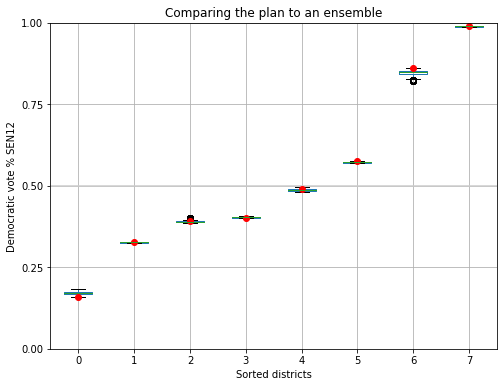

In [ ]:
import pandas
import matplotlib.pyplot as plt

#for election in elections:
election = elections[0]
display(Markdown('# {}'.format(election.name)))

pprint(election)

for partition in list(chain)[:1]:
  print('blah')
  for key, value in list(partition.parts.items())[:10]:
    print(key, value)
  break
  

d_percents = [sorted(partition[election.name].percents("Dem")) for partition in chain]

data = pandas.DataFrame(d_percents)


fig, ax = plt.subplots(figsize=(8, 6))
# Draw 50% line
ax.axhline(0.5, color="#cccccc")
data.boxplot(positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the plan to an ensemble")
ax.set_ylabel("Democratic vote % {}".format(election.name))
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

# Next Steps

Many possibilities are detailed in the [Madison Civic Hacking Redistricting Follow-Up Resources](https://docs.google.com/document/d/1iW0A7lSslCggYZsYKxGLFIGCijMXUd0IvrS9MXsE2lA/edit?usp=sharing) doc.